In [ ]:
from typing import List
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Генерация изображений

Самостоятельно выбранными средствами (opencv, pillow (PIL), …) сгенерировать по 820 картинок размером 100х100 пикселей (px) для каждой из цифр: 0, 1, 3, 8 следующим образом (800 – тренировочная выборка, 20 – тестовая выборка № 1):
*	фон картинки белый,
*	цифра: ширина – 20 px, высота – 50 px, цвет линии – черный, цифра целиком помещается в картинку, цифра находится в случайном месте на картинке,
*	на изображении цифра расположена так, что ее вертикальная ось параллельна оси ординат (вертикальное положение) или оси абсцисс (горизонтальное положение),
*	тренировочная выборка содержит 400 изображений каждой цифры в горизонтальном положении и 400 изображений каждой цифры в вертикальном положении,
*	тестовая выборка содержит 10 изображений каждой цифры в горизонтальном положении и 10 изображений каждой цифры в вертикальном положении,

Создать новые тестовые картинки, полученные путем добавления черных пикселей (шум) в случайно выбранные места сгенерированных тестовых картинок:
*	20 px (тестовая выборка № 2),
*	50 px (тестовая выборка № 3),
*	100 px (тестовая выборка № 4),
*	200 px (тестовая выборка № 5).

In [ ]:
class MNISTGenerator():
  def __init__(self, image_size: int):
    self.image_size = image_size

  def generate_images(self, orientation_images_count: int, numbers: List[int], is_noisy: bool = False, noise_count: int = 0):
    self.is_noisy = is_noisy
    self.noise_count = noise_count

    images = []
    labels = []

    for number in numbers:
      number_images = []
      for _ in range(orientation_images_count):
        image = self.generate_image(number, True)
        number_images.append(image)
        labels.append(number)

        image = self.generate_image(number, False)
        number_images.append(image)
        labels.append(number)

      images.append(number_images)

    images = np.stack(images, axis=0)
    labels = np.array(labels)

    return images, labels

  def generate_image(self, number: int, is_rotate: bool):
    image = np.full((self.image_size, self.image_size, 1), 255, dtype=np.uint8)
    number_image = self.generate_number_image(number)

    x = np.random.randint(0, self.image_size - 50 - 1)
    y = np.random.randint(0, self.image_size - 20 - 1)
    image[x:x+50, y:y+20] = number_image

    if is_rotate:
      image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
      image = image[..., np.newaxis]

    if self.is_noisy:
      for _ in range(self.noise_count):
        x, y = np.random.randint(0, 100, 2)
        image[x, y, :] = 0 if image[x, y] == 255 else 255
    return image

  def generate_number_image(self, number: int):
    fonts = [cv2.FONT_HERSHEY_COMPLEX, cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_DUPLEX]
    number_image = np.full((50, 20, 1), 255, dtype=np.uint8)
    cv2.putText(number_image, str(number), (-3, 40), fonts[np.random.randint(0, 3)], 1.25, (0, 0, 0), 1)

    return number_image

In [ ]:
numbers = [0, 1, 3, 8]

mnist_generator = MNISTGenerator(100)
train_images, train_labels = mnist_generator.generate_images(400, [0, 1, 3, 8])
test_images1, test_labels1 = mnist_generator.generate_images(10, numbers)
test_images2, test_labels2 = mnist_generator.generate_images(10, numbers, True, 20)
test_images3, test_labels3 = mnist_generator.generate_images(10, numbers, True, 50)
test_images4, test_labels4 = mnist_generator.generate_images(10, numbers, True, 100)
test_images5, test_labels5 = mnist_generator.generate_images(10, numbers, True, 200)

(4, 800, 100, 100, 1)


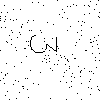

In [ ]:
print(train_images.shape)
img = test_images5[2][0]
cv2_imshow(img)

In [ ]:
train_images = train_images.reshape(-1, 1, 100, 100)
test_images1 = test_images1.reshape(-1, 1, 100, 100)
test_images2 = test_images2.reshape(-1, 1, 100, 100)
test_images3 = test_images3.reshape(-1, 1, 100, 100)
test_images4 = test_images4.reshape(-1, 1, 100, 100)
test_images5 = test_images5.reshape(-1, 1, 100, 100)

In [ ]:
np.save('/content/train_images', train_images)

In [ ]:
np.save('/content/test_images1', test_images1)
np.save('/content/test_images2', test_images2)
np.save('/content/test_images3', test_images3)
np.save('/content/test_images4', test_images4)
np.save('/content/test_images5', test_images5)


# Обучение модели

Не используя предобученные модели (сети), написать свою нейронную сеть на keras или torch такую, что:
1. На вход подается тренировочное множество: по 800 картинок каждой цифры.
2. Из тренировочного множества выделяется часть картинок (10–20%), на валидационное множество, в котором должны присутствовать цифры в вертикальном и горизонтальном положении.
3. Протестировать адекватность модели на всех тестовых выборках № 1, № 2, № 3, № 4, № 5, фиксируя при этом точность (accuracy) классификации.
4. Повторить пункты 1)–3), изменив объем тренировочной выборки до 600, 400, 200, 100 картинок каждой цифры.

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, images, labels):
    self.images = torch.from_numpy(images).float()
    self.img_labels = torch.from_numpy(labels).long()

  def __len__(self):
      return len(self.img_labels)

  def __getitem__(self, idx):
    return self.images[idx], self.img_labels[idx]

In [ ]:
train_dataset = CustomImageDataset(train_images, train_labels)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

test_dataset1 = CustomImageDataset(test_images1, test_labels1)
test_dataset2 = CustomImageDataset(test_images2, test_labels2)
test_dataset3 = CustomImageDataset(test_images3, test_labels3)
test_dataset4 = CustomImageDataset(test_images4, test_labels4)
test_dataset5 = CustomImageDataset(test_images5, test_labels5)

train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25, shuffle=False)
test_dataloader1 = DataLoader(test_dataset1, batch_size=25, shuffle=False)
test_dataloader2 = DataLoader(test_dataset2, batch_size=25, shuffle=False)
test_dataloader3 = DataLoader(test_dataset3, batch_size=25, shuffle=False)
test_dataloader4 = DataLoader(test_dataset4, batch_size=25, shuffle=False)
test_dataloader5 = DataLoader(test_dataset5, batch_size=25, shuffle=False)

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d((2, 2)),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d((2, 2)),
    )

    self.flatten = nn.Flatten()

    self.linear_layers = nn.Sequential(
        nn.Linear(32 * 22 * 22, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 9)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.flatten(x)
    x = self.linear_layers(x)
    return x

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Linear(in_features=15488, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=9, bias=True)
  )
)


In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(train_dataloader, val_dataloader, model, loss_fn, optimizer):
    size = len(train_dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    model.eval()
    with torch.no_grad():
      for batch, (X, y) in enumerate(val_dataloader):
          X, y = X.to(device), y.to(device)

          pred = model(X)
          loss = loss_fn(pred, y)

          if batch % 100 == 0:
              loss, current = loss.item(), (batch + 1) * len(X)
              print(f"Validation loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Обучение на полном датасете(800 изображений)

In [ ]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, val_dataloader, model, loss_function, optimizer)

test(test_dataloader1, model, loss_function)
test(test_dataloader2, model, loss_function)
test(test_dataloader3, model, loss_function)
test(test_dataloader4, model, loss_function)
test(test_dataloader5, model, loss_function)

Epoch 1
-------------------------------
Train loss: 11.589921  [   25/ 2560]
Train loss: 1.370283  [ 2525/ 2560]
Validation loss: 1.404120  [   25/ 2560]
Epoch 2
-------------------------------
Train loss: 1.208860  [   25/ 2560]
Train loss: 1.348949  [ 2525/ 2560]
Validation loss: 1.311044  [   25/ 2560]
Epoch 3
-------------------------------
Train loss: 1.110236  [   25/ 2560]
Train loss: 1.289418  [ 2525/ 2560]
Validation loss: 1.075977  [   25/ 2560]
Epoch 4
-------------------------------
Train loss: 0.695301  [   25/ 2560]
Train loss: 0.685476  [ 2525/ 2560]
Validation loss: 0.686152  [   25/ 2560]
Epoch 5
-------------------------------
Train loss: 0.573849  [   25/ 2560]
Train loss: 0.724627  [ 2525/ 2560]
Validation loss: 0.629429  [   25/ 2560]
Epoch 6
-------------------------------
Train loss: 0.353501  [   25/ 2560]
Train loss: 0.522695  [ 2525/ 2560]
Validation loss: 0.500416  [   25/ 2560]
Epoch 7
-------------------------------
Train loss: 0.146887  [   25/ 2560]
Train

Обучение на датасете из 600 фотографий

In [ ]:
train_images, train_labels = mnist_generator.generate_images(300, [0, 1, 3, 8])
train_images = train_images.reshape(-1, 1, 100, 100)
np.save('/content/train_images600', train_images)
train_dataset = CustomImageDataset(train_images, train_labels)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25, shuffle=False)

model = NeuralNetwork().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, val_dataloader, model, loss_function, optimizer)

Epoch 1
-------------------------------
Train loss: 33.940197  [   25/ 1920]
Validation loss: 1.431488  [   25/ 1920]
Epoch 2
-------------------------------
Train loss: 1.359533  [   25/ 1920]
Validation loss: 1.313603  [   25/ 1920]
Epoch 3
-------------------------------
Train loss: 1.166482  [   25/ 1920]
Validation loss: 1.313335  [   25/ 1920]
Epoch 4
-------------------------------
Train loss: 0.752054  [   25/ 1920]
Validation loss: 1.296334  [   25/ 1920]
Epoch 5
-------------------------------
Train loss: 0.522342  [   25/ 1920]
Validation loss: 1.071410  [   25/ 1920]
Epoch 6
-------------------------------
Train loss: 0.540847  [   25/ 1920]
Validation loss: 1.008933  [   25/ 1920]
Epoch 7
-------------------------------
Train loss: 0.329657  [   25/ 1920]
Validation loss: 0.946744  [   25/ 1920]
Epoch 8
-------------------------------
Train loss: 0.363656  [   25/ 1920]
Validation loss: 1.063683  [   25/ 1920]
Epoch 9
-------------------------------
Train loss: 0.456427  [

In [ ]:
test(test_dataloader1, model, loss_function)
test(test_dataloader2, model, loss_function)
test(test_dataloader3, model, loss_function)
test(test_dataloader4, model, loss_function)
test(test_dataloader5, model, loss_function)

Test Error: 
 Accuracy: 77.5%, Avg loss: 0.845154 

Test Error: 
 Accuracy: 81.2%, Avg loss: 0.659999 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.819388 

Test Error: 
 Accuracy: 75.0%, Avg loss: 1.051942 

Test Error: 
 Accuracy: 62.5%, Avg loss: 1.236836 



Обучение на датасете из 400 фотографий

In [ ]:
train_images, train_labels = mnist_generator.generate_images(200, [0, 1, 3, 8])
train_images = train_images.reshape(-1, 1, 100, 100)
np.save('/content/train_images400', train_images)
train_dataset = CustomImageDataset(train_images, train_labels)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25, shuffle=False)

model = NeuralNetwork().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, val_dataloader, model, loss_function, optimizer)

Epoch 1
-------------------------------
Train loss: 29.392088  [   25/ 1280]
Validation loss: 2.157323  [   25/ 1280]
Epoch 2
-------------------------------
Train loss: 2.148361  [   25/ 1280]
Validation loss: 2.002250  [   25/ 1280]
Epoch 3
-------------------------------
Train loss: 1.970669  [   25/ 1280]
Validation loss: 1.806314  [   25/ 1280]
Epoch 4
-------------------------------
Train loss: 1.754954  [   25/ 1280]
Validation loss: 1.643488  [   25/ 1280]
Epoch 5
-------------------------------
Train loss: 1.584995  [   25/ 1280]
Validation loss: 1.553641  [   25/ 1280]
Epoch 6
-------------------------------
Train loss: 1.508117  [   25/ 1280]
Validation loss: 1.496168  [   25/ 1280]
Epoch 7
-------------------------------
Train loss: 1.486790  [   25/ 1280]
Validation loss: 1.462557  [   25/ 1280]
Epoch 8
-------------------------------
Train loss: 1.450640  [   25/ 1280]
Validation loss: 1.439210  [   25/ 1280]
Epoch 9
-------------------------------
Train loss: 1.431860  [

In [ ]:
test(test_dataloader1, model, loss_function)
test(test_dataloader2, model, loss_function)
test(test_dataloader3, model, loss_function)
test(test_dataloader4, model, loss_function)
test(test_dataloader5, model, loss_function)

Test Error: 
 Accuracy: 25.0%, Avg loss: 1.392594 

Test Error: 
 Accuracy: 25.0%, Avg loss: 1.392594 

Test Error: 
 Accuracy: 25.0%, Avg loss: 1.392594 

Test Error: 
 Accuracy: 25.0%, Avg loss: 1.392594 

Test Error: 
 Accuracy: 25.0%, Avg loss: 1.392594 



Обучение на датасете из 200 фотографий

In [ ]:
train_images, train_labels = mnist_generator.generate_images(100, [0, 1, 3, 8])
train_images = train_images.reshape(-1, 1, 100, 100)
np.save('/content/train_images200', train_images)
train_dataset = CustomImageDataset(train_images, train_labels)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25, shuffle=False)

model = NeuralNetwork().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, val_dataloader, model, loss_function, optimizer)

Epoch 1
-------------------------------
Train loss: 45.883297  [   25/  640]
Validation loss: 2.185917  [   25/  640]
Epoch 2
-------------------------------
Train loss: 2.207531  [   25/  640]
Validation loss: 1.805618  [   25/  640]
Epoch 3
-------------------------------
Train loss: 1.816460  [   25/  640]
Validation loss: 1.443244  [   25/  640]
Epoch 4
-------------------------------
Train loss: 1.305037  [   25/  640]
Validation loss: 1.371960  [   25/  640]
Epoch 5
-------------------------------
Train loss: 1.193123  [   25/  640]
Validation loss: 1.561918  [   25/  640]
Epoch 6
-------------------------------
Train loss: 0.691519  [   25/  640]
Validation loss: 1.531852  [   25/  640]
Epoch 7
-------------------------------
Train loss: 0.829240  [   25/  640]
Validation loss: 1.953429  [   25/  640]
Epoch 8
-------------------------------
Train loss: 0.789030  [   25/  640]
Validation loss: 1.474583  [   25/  640]
Epoch 9
-------------------------------
Train loss: 0.577715  [

In [ ]:
test(test_dataloader1, model, loss_function)
test(test_dataloader2, model, loss_function)
test(test_dataloader3, model, loss_function)
test(test_dataloader4, model, loss_function)
test(test_dataloader5, model, loss_function)

Test Error: 
 Accuracy: 35.0%, Avg loss: 3.737062 

Test Error: 
 Accuracy: 35.0%, Avg loss: 5.753876 

Test Error: 
 Accuracy: 31.2%, Avg loss: 5.063991 

Test Error: 
 Accuracy: 33.8%, Avg loss: 5.259412 

Test Error: 
 Accuracy: 43.8%, Avg loss: 3.678627 



Обучение на датасете из 100 фотографий

In [ ]:
train_images, train_labels = mnist_generator.generate_images(50, [0, 1, 3, 8])
train_images = train_images.reshape(-1, 1, 100, 100)
np.save('/content/train_images100', train_images)

train_dataset = CustomImageDataset(train_images, train_labels)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25, shuffle=False)

model = NeuralNetwork().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, val_dataloader, model, loss_function, optimizer)

Epoch 1
-------------------------------
Train loss: 17.561781  [   25/  320]
Validation loss: 7.865322  [   25/  320]
Epoch 2
-------------------------------
Train loss: 5.439832  [   25/  320]
Validation loss: 1.796261  [   25/  320]
Epoch 3
-------------------------------
Train loss: 1.501889  [   25/  320]
Validation loss: 1.762641  [   25/  320]
Epoch 4
-------------------------------
Train loss: 1.159244  [   25/  320]
Validation loss: 1.657158  [   25/  320]
Epoch 5
-------------------------------
Train loss: 1.022052  [   25/  320]
Validation loss: 1.674585  [   25/  320]
Epoch 6
-------------------------------
Train loss: 0.900782  [   25/  320]
Validation loss: 1.735855  [   25/  320]
Epoch 7
-------------------------------
Train loss: 0.611478  [   25/  320]
Validation loss: 1.938621  [   25/  320]
Epoch 8
-------------------------------
Train loss: 0.329772  [   25/  320]
Validation loss: 2.014135  [   25/  320]
Epoch 9
-------------------------------
Train loss: 0.255726  [

In [ ]:
test(test_dataloader1, model, loss_function)
test(test_dataloader2, model, loss_function)
test(test_dataloader3, model, loss_function)
test(test_dataloader4, model, loss_function)
test(test_dataloader5, model, loss_function)

Test Error: 
 Accuracy: 36.2%, Avg loss: 6.698916 

Test Error: 
 Accuracy: 38.8%, Avg loss: 5.446739 

Test Error: 
 Accuracy: 31.2%, Avg loss: 4.478997 

Test Error: 
 Accuracy: 43.8%, Avg loss: 3.643229 

Test Error: 
 Accuracy: 33.8%, Avg loss: 5.033852 



# Тестирование

Результаты оформить в виде таблицы со столбцами: размер тренировочной выборки, количество шумовых пикселей, точность (accuracy) классификации. Полученные наборы изображений сохранить для следующих лабораторных работ.

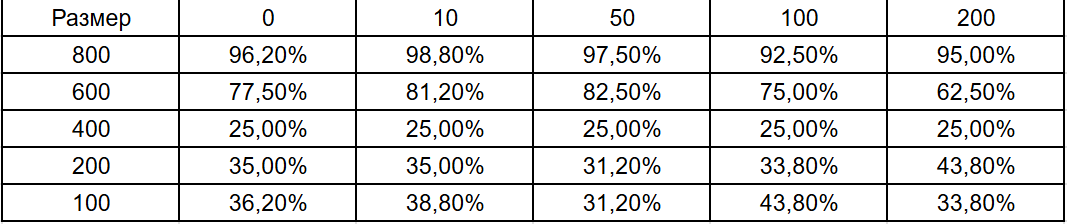

In [ ]:
!mkdir /content/train_images
!mv /content/*images*.npy /content/train_images

In [ ]:
!cp -r /content/train_images/ /content/drive/MyDrive/ForColab